____

# <font color=#FFAA11> Two-Temperature Model </font>

The TTM considered here is given by
$$\begin{align}
c_e\frac{\partial T_e}{\partial t}   &= - \frac{1}{r}\frac{\partial}{\partial r}\left[ r \left(  v(P_e+E_e) - k_e \frac{\partial T_e}{\partial r}\right) \right]  - G (T_e - T_i), \\
c_i\frac{\partial T_i}{\partial t}  &= - \frac{1}{r}\frac{\partial}{\partial r} \left[ r \left(  v(P_i+E_i) - k_i \frac{\partial T_i}{\partial r}\right) \right] + G (T_e - T_i)
\end{align}
$$
which assumes a cylindrical plasma composed of electrons and ions.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors


from pandas import read_csv
from physics import JT_GMS, SMT
from constants import *

from scipy.optimize import root, curve_fit, least_squares
from scipy.interpolate import interp1d
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
""
from exp_setup import Cylindrical_Grid, Experiment, Measurements
# from TTM_solver import TwoTemperatureModel
from Hydro_solver import HydroModel

import cProfile

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Experimental Setup

In [2]:
grid  = Cylindrical_Grid(200e-6, N=200) 
Z, A = 54, 131
n0 = 1.25e20 *1e6

dih_file = "/home/zach/plasma/TTM/data/Xe5bar_DIH_profile_data.txt"

model_kwargs = {'gas_name':'Xenon', 'model':"SMT", 'ion_temperature_model':'MD','ion_temperature_file':dih_file,
                'electron_temperature_model':'gaussian','Te_experiment_is_peak':True, 'super_gaussian_power':1}

Xe_data = read_csv("./data/experimental_data/Xe_5bar_Te.txt", delim_whitespace=True, header=1)
Xe_FWHM_data = read_csv("./data/experimental_data/Xe_5bar_FWHM.txt", delim_whitespace=True, header=1)


### Fit to Initial Experimental Values

In [3]:
import warnings
# Suppress warnings from fitting initial conditions
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    def fit_initial_condition(Te_exp, FWHM_exp , **kwargs ):
        def find_exp_params(inputs):
            Te_peak, Te_FWHM = inputs
            Xenon_jt = Experiment(grid, n0, Z, A, Te_peak, Te_FWHM, **kwargs)

            ttm = HydroModel(Xenon_jt, model=kwargs['model'])
            exp = Measurements(Z, A, ttm.grid.r, ttm.n_e, ttm.n_i, ttm.Te, ttm.Ti, R_max = 100e-6, Nx =100, Nz=100)
            return Te_exp - exp.Te_fit, FWHM_exp - exp.FWHM 
#         sol = root(find_exp_params, (Te_exp, 2*FWHM_exp))
        sol = root(find_exp_params, (1.15*Te_exp, 102.4e-6))
        return sol

    initial_conditions = fit_initial_condition(Xe_data['T[kK]'][0]*1e3, Xe_FWHM_data['FWHM[μm]'][0]/1e6,**model_kwargs)
# Show success of initial condition fit     
print(initial_conditions)
Te_initial, gaussian_FWHM = initial_conditions.x
Xenon = Experiment(grid, n0, Z, A, Te_initial, gaussian_FWHM, **model_kwargs)

ttm = HydroModel(Xenon, model = model_kwargs["model"], electron_model='equilibrium')

# Print Setup
initial_setup = Measurements(Z, A, ttm.grid.r, ttm.n_e, ttm.n_i, ttm.Te, ttm.Ti, R_max = 200e-6, Nx =200, Nz=100)
print("\nExp: FWHM = {0:.2f} [μm], Te = {1:.2f} [kK]".format(Xe_FWHM_data['FWHM[μm]'][0], Xe_data['T[kK]'][0]))
print("Sim: FWHM = {0:.2f} [μm], Te = {1:.2f} [kK]".format(initial_setup.FWHM*1e6,initial_setup.Te_fit/1e3))

 message: The iteration is not making good progress, as measured by the 
            improvement from the last ten iterations.
 success: False
  status: 5
     fun: [-2.576e+02 -1.573e-07]
       x: [ 1.881e+04  1.039e-04]
    nfev: 38
    fjac: [[-1.000e+00 -8.884e-10]
           [ 8.884e-10 -1.000e+00]]
       r: [-6.491e-02  2.411e+08  2.720e-01]
     qtf: [ 2.576e+02 -7.154e-08]


/home/zach/plasma/TTM/physics.py:306: RuntimeWarning: invalid value encountered in sqrt
  l_mfp = c/ν_ω * np.sqrt(1-γ)/γ
/home/zach/plasma/TTM/physics.py:358: RuntimeWarning: overflow encountered in exp
  B_λ = 4*π*hbar * c**2/λ**5 * 1/(np.exp(2*π*hbar*c/(λ*k_B*Te))-1)



Exp: FWHM = 51.18 [μm], Te = 16.61 [kK]
Sim: FWHM = 51.37 [μm], Te = 16.85 [kK]


### Plot of Photon Mean Free Path

/tmp/ipykernel_5876/1504741410.py:8: RuntimeWarning: invalid value encountered in sqrt
  correction = crit_ratio_grid/np.sqrt(1-crit_ratio_grid)
/home/zach/plasma/TTM/physics.py:306: RuntimeWarning: invalid value encountered in sqrt
  l_mfp = c/ν_ω * np.sqrt(1-γ)/γ


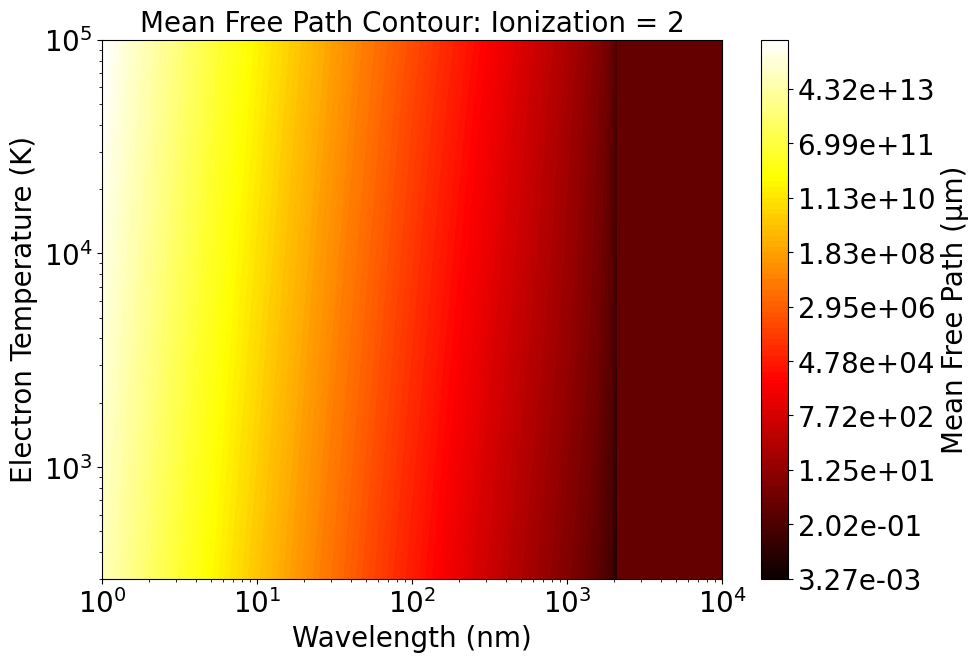

In [3]:
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter

Ionization = 2

def get_lγ_from_Te_Seth(ω, Te):
    Ti   = 1e3 # really irrelevant
    correction = crit_ratio_grid/np.sqrt(1-crit_ratio_grid)
    l = 1/correction*JT_GMS.photon_mean_free_path(ω, A*m_p, n0, n_e_grid, Ti, Te)
    return l

def get_lγ_from_Te_standard(ω, Te):
    Ti   = 1e3 # really irrelevant
    l = 1/JT_GMS.photon_absorption_coefficient(ω, A*m_p, n0, n_e_grid, Ti, Te)
    return l

# Create a grid of angular frequencies (ω) and electron temperatures (Te)
# λ_values = 1e-9*np.geomspace(400,700, 1000)  # m 
λ_values = 1e-9*np.geomspace(1, 1e4, 1000)
ω_values = 2*π*c/λ_values # Corresponds to 1 nm to 1000 nm
Te_values = np.geomspace(3e2, 1e5, 1000)  # K

# Create a 2D grid
ω_grid, Te_grid = np.meshgrid(ω_values, Te_values)

if Ionization=='TF':
    n_e_grid = n0*ttm.experiment.get_ionization(Z, n0, Te_grid)
elif type(Ionization) is int:
    n_e_grid = n0*Ionization

ωp_grid = JT_GMS.electron_plasma_frequency(n_e_grid)
crit_ratio_grid = (ωp_grid/ω_grid)**2

# Calculate mean free path on this grid
lγ_grid = get_lγ_from_Te_Seth(ω_grid, Te_grid) * 1e6  # Convert from m to μm
lγ_grid = np.nan_to_num(lγ_grid, nan=1)
# Make the contour plot
plt.figure(figsize=(10, 7))

# Apply log scale to the colorbar and colormap
norm = LogNorm(vmin=lγ_grid.min(), vmax=lγ_grid.max())
levels = np.logspace(np.log10(lγ_grid.min()), np.log10(lγ_grid.max()), num=100)
contour = plt.contourf(λ_values*1e9, Te_values, lγ_grid, levels=levels, cmap='hot', norm=norm)

# Create colorbar, add label, and set label size
cbar = plt.colorbar(contour, format=FuncFormatter(lambda x, pos: "{:.2e}".format(x)))
cbar.set_label('Mean Free Path (μm)', size=20)
cbar.ax.tick_params(labelsize=20)


plt.xscale('log')
plt.yscale('log')

# Set label sizes
plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Electron Temperature (K)', fontsize=20)
plt.title(f'Mean Free Path Contour: Ionization = {Ionization}', fontsize=20)

# Set tick label sizes
plt.tick_params(labelsize=20, which='both')

plt.show()

/tmp/ipykernel_5876/2775233261.py:8: RuntimeWarning: invalid value encountered in sqrt
  contour = plt.contourf(λ_values*1e9, Te_values, crit_ratio_grid/np.sqrt(1-crit_ratio_grid), levels=levels, cmap='jet', norm=norm)


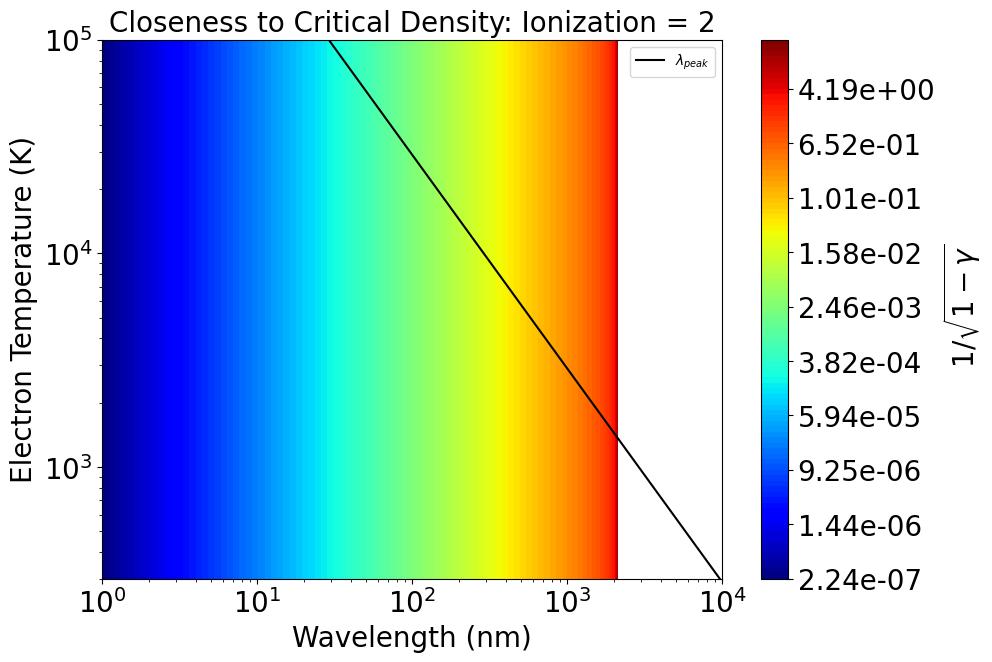

In [5]:
plt.figure(figsize=(10, 7))

ωp_grid = JT_GMS.electron_plasma_frequency(n_e_grid)
crit_ratio_grid = (ωp_grid/ω_grid)**2

norm = LogNorm(vmin=crit_ratio_grid.min(), vmax=crit_ratio_grid.max())
levels = np.logspace(np.log10(crit_ratio_grid.min()), np.log10(crit_ratio_grid.max()), num=100)
contour = plt.contourf(λ_values*1e9, Te_values, crit_ratio_grid/np.sqrt(1-crit_ratio_grid), levels=levels, cmap='jet', norm=norm)
# contour = plt.contourf(λ_values*1e9, Te_values, crit_ratio_grid, levels=levels, cmap='jet', norm=norm)

# Create colorbar, add label, and set label size
cbar = plt.colorbar(contour, format=FuncFormatter(lambda x, pos: "{:.2e}".format(x)))
# cbar.set_label(r" $\gamma = \left( \omega_p/\omega \right)^2$ ", size=20)
cbar.set_label(r" $1/\sqrt{1-\gamma}$ ", size=20)
cbar.ax.tick_params(labelsize=20)

plt.plot(λ_values*1e9, 2.897e-3/λ_values ,'k', label=r"$\lambda_{peak}$")

plt.xscale('log')
plt.yscale('log')
plt.ylim(3e2,1e5)
# Set label sizes
plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Electron Temperature (K)', fontsize=20)
plt.title(f'Closeness to Critical Density: Ionization = {Ionization}', fontsize=20)

# Set tick label sizes
plt.tick_params(labelsize=20, which='both')

plt.legend()
plt.show()

/tmp/ipykernel_5876/3738894768.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('hot')


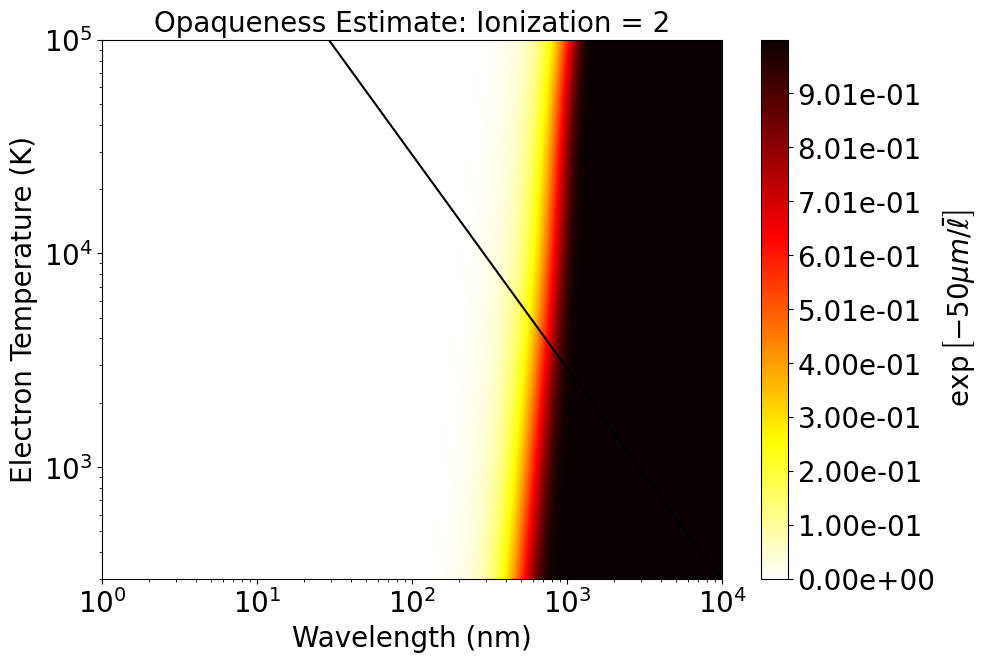

In [6]:
plt.figure(figsize=(10, 7))

orig_map=plt.cm.get_cmap('hot')
reversed_hot = orig_map.reversed()

contour = plt.contourf(λ_values*1e9, Te_values, 1-np.exp(-50/lγ_grid), levels=np.linspace(0,1,num=1000), cmap=reversed_hot)#, norm=norm)

# Create colorbar, add label, and set label size
cbar = plt.colorbar(contour, format=FuncFormatter(lambda x, pos: "{:.2e}".format(x)))
cbar.set_label(r" $\exp\left[-50 \mu m/\bar{\ell} \right]$ ", size=20)
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylim(0,1)

plt.plot(λ_values*1e9, 2.897e-3/λ_values ,'k', label=r"$\lambda_{peak}$")

# Axes
plt.xscale('log')
plt.yscale('log')
plt.ylim(np.min(Te_values), np.max(Te_values))

# Set label sizes
plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Electron Temperature (K)', fontsize=20)
plt.title(f'Opaqueness Estimate: Ionization = {Ionization}', fontsize=20)

# Set tick label sizes
plt.tick_params(labelsize=20, which='both')

plt.show()

### Plotting Initial Experimental Setup

In [ ]:
initial_setup.plot_parameter( np.sum(initial_setup.ε_grid,axis=2), "Te")

In [ ]:
initial_setup.plot_parameter( np.sum(initial_setup.Iλ_grid,axis=2)/np.sum(initial_setup.Bλ_grid, axis=2), "ε")

In [ ]:
initial_setup.plot_parameter( np.log(np.sum(initial_setup.Iλ_grid,axis=2)), "Te")

In [ ]:
initial_setup.plot_emissivity_and_intensity(cmap='afmhot')
initial_setup.plot_spectral_Intensity()

In [ ]:
def dumb_plot():
    fig, ax = plt.subplots()
    r = np.linspace(0,5)
    a=1
    λ = 1
    Γ=1
    ax.plot(r ,1-  Γ*a/r*np.exp(-r/λ))
    ax.set_ylim(0,1.2)    
    
dumb_plot()


In [ ]:
fig, ax = plt.subplots()
ax.plot(ttm.grid.r*1e6,  JT_GMS.Gamma(ttm.n_e,ttm.Te,Z=1))

In [ ]:
from scipy.special import lambertw as W0
Uid = ttm.n_e* k_B*ttm.Te
    Uex = -2*π*ttm.n_e**2*(ee**2/(4*π*ε_0))**2*JT_GMS.total_Debye_length(ttm.n_e, ttm.n_i, ttm.Ti, ttm.Te, ttm.Zbar)/(k_B*ttm.Te)
Uex/Uid*np.exp(-W0(JT_GMS.Gamma(ttm.n_e,ttm.Te,Z=1)*JT_GMS.r_WignerSeitz(ttm.n_e)/JT_GMS.total_Debye_length(ttm.n_e, ttm.n_i, ttm.Ti, ttm.Te, ttm.Zbar)))